# MNIST data-set and Simple Linear Model

In [4]:
# Load data
from Utils.mnist import MNIST
data = MNIST(data_dir="data/MNIST")

- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!
- Download progress: 100.0% Done!


In [5]:
print("Size of:")
print("- Training-set:\t\t{}".format(data.num_train))
print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(data.num_test))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [6]:
# The images are stored in one-dimensional arrays of this length.
img_size_flat = data.img_size_flat

# Tuple with height and width of images used to reshape arrays.
img_shape = data.img_shape

# Number of classes, one class for each of 10 digits.
num_classes = data.num_classes

### One-Hot Encoding
The output-data is loaded as both integer class-numbers and so-called One-Hot encoded arrays. This means the class-numbers have been converted from a single integer to a vector whose length equals the number of possible classes. All elements of the vector are zero except for the $i$'th element which is 1 and means the class is $i$. For example, the One-Hot encoded labels for the first 5 images in the test-set are:

In [9]:
data.y_test[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
from util.helper import plot_images
import matplotlib.pyplot as plt
%matplotlib inline

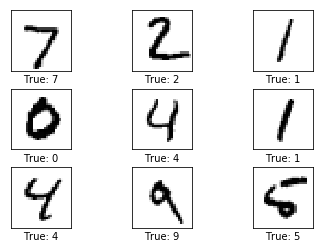

In [11]:
# Get the first images from the test-set.
images = data.x_test[0:9]

# Get the true classes for those images.
cls_true = data.y_test_cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, img_shape=img_shape, cls_true=cls_true)

### Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [12]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [13]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Finally we have the placeholder variable for the true class of each image in the placeholder variable x. These are integers and the dimensionality of this placeholder variable is set to [None] which means the placeholder variable is a one-dimensional vector of arbitrary length.

In [14]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

Apart from the placeholder variables that were defined above and which serve as feeding input data into the model, there are also some model variables that must be changed by TensorFlow so as to make the model perform better on the training data.

In [15]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
lamb = tf.Variable(0.01)

### Model

This simple mathematical model multiplies the images in the placeholder variable `x` with the `weights`.

$$ f = W . x$$

The result is a matrix of shape `[num_images, num_classes]` because `x` has shape `[num_images, img_size_flat]` and `weights` has shape `[img_size_flat, num_classes]`, so the multiplication of those two matrices is a matrix with shape `[num_images, num_classes]` and then the `biases` vector is added to each row of that matrix.

In [16]:
y_pred = tf.matmul(x, weights)
y_pred_cls = tf.argmax(y_pred, axis=1)

Now `y_pred` is a matrix with `num_images` rows and `num_classes` columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.

### Cost-function to be optimized

To make the model better at classifying the input images, we must somehow change the variables for `weights`.
To do this we first need to know how well the model currently performs by comparing the predicted output of the model `y_pred` to the desired output `y_true`.

In [17]:
L = tf.losses.hinge_loss(logits=y_pred, labels=y_true)
regularizer = tf.nn.l2_loss(weights)

In [18]:
loss = tf.reduce_mean(L + lamb * regularizer) 

### Optimization method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.5.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005).minimize(loss)

### Performance measures

We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [22]:
session = tf.Session()

### Initialize variables

The variables for `weights` and `lamb` must be initialized before we start optimizing them.

In [23]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55.000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore use Stochastic Gradient Descent which only uses a small batch of images in each iteration of the optimizer.

In [24]:
batch_size = 100

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `lamb` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [25]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions to "Visualization"

Dict with the test-set data to be used as input to the TensorFlow graph. Note that we must use the correct names for the placeholder variables in the TensorFlow graph.

In [26]:
feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
def print_confusion_matrix():
    cls_true = data.y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()
    
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    
    plot_images(images=images[0:9],
                img_shape=img_shape,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_weights():
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(img_shape)

            ax.set_xlabel("Weights: {0}".format(i))

            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

## Performance before any optimization

The accuracy on the test-set is 9.8%. This is because the model has only been initialized and not optimized at all, so it always predicts that the image shows a zero digit, as demonstrated in the plot below, and it turns out that 9.8% of the images in the test-set happens to be zero digits.

In [28]:
print_accuracy()

Accuracy on test-set: 9.8%


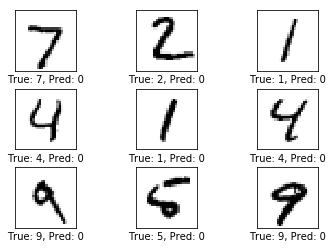

In [29]:
plot_example_errors()

## Performance after 1 optimization iteration

Already after a single optimization iteration, the model has increased its accuracy on the test-set significantly.

In [30]:
optimize(num_iterations=1)

In [31]:
print_accuracy()

Accuracy on test-set: 34.5%


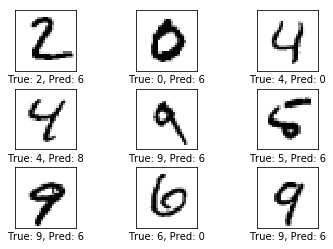

In [32]:
plot_example_errors()

The weights can also be plotted as shown below. Positive weights are red and negative weights are blue. These weights can be intuitively understood as image-filters.

For example, the weights used to determine if an image shows a zero-digit have a positive reaction (red) to an image of a circle, and  have a negative reaction (blue) to images with content in the centre of the circle.

Similarly, the weights used to determine if an image shows a one-digit react positively (red) to a vertical line in the centre of the image, and react negatively (blue) to images with content surrounding that line.

Note that the weights mostly look like the digits they're supposed to recognize. This is because only one optimization iteration has been performed so the weights are only trained on 100 images. After training on several thousand images, the weights become more difficult to interpret because they have to recognize many variations of how digits can be written.

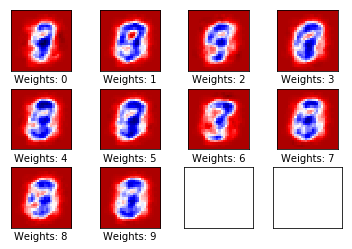

In [33]:
plot_weights()

## Performance after 10 optimization iterations

In [34]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [35]:
print_accuracy()

Accuracy on test-set: 48.8%


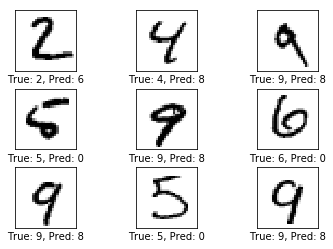

In [36]:
plot_example_errors()

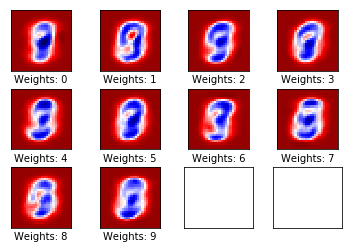

In [37]:
plot_weights()

## Performance after 100 optimization iterations

In [38]:
# We have already performed 10 iterations.
optimize(num_iterations=90)

In [39]:
print_accuracy()

Accuracy on test-set: 71.6%


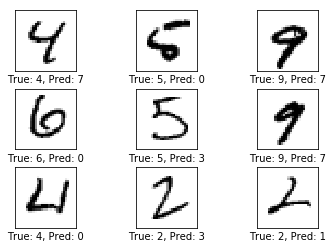

In [40]:
plot_example_errors()

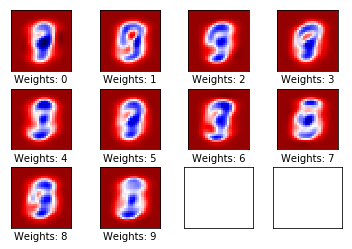

In [41]:
plot_weights()

[[ 952    1    2    7    0    0   12    2    4    0]
 [   0 1118    1    5    0    0    4    1    6    0]
 [  76  135  683   36    6    0   32   37   23    4]
 [  31   24   16  884    0    0    9   28   10    8]
 [  21   52    2    3  607    0   40   27    5  225]
 [ 234  100    3  309    8   47   39   76   36   40]
 [  81   33   10    3    1    0  828    1    1    0]
 [  13   67   18    1    0    0    2  911    2   14]
 [  63  129   14  184    2    0   24   48  476   34]
 [  45   36    9   18   16    0    4  225    2  654]]


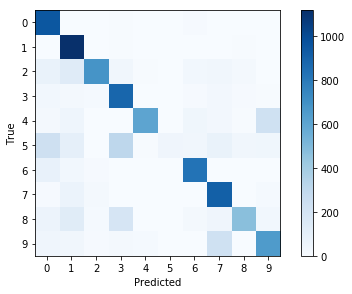

In [42]:
print_confusion_matrix()

# How we can improve results? 

In [43]:
session.close()
tf.reset_default_graph()

In [44]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

Add biases term!

In [45]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [46]:
logits = tf.matmul(x, weights) + biases

these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the `logits` matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in `y_pred`.

In [47]:
y_pred = tf.nn.softmax(logits)

In [48]:
y_pred_cls = tf.argmax(y_pred, axis=1)

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the `weights` and `biases` of the model.


In [49]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [50]:
cost = tf.reduce_mean(cross_entropy)

In [51]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [52]:
session = tf.Session()
session.run(tf.global_variables_initializer())
batch_size = 100

feed_dict_test = {x: data.x_test,
                  y_true: data.y_test,
                  y_true_cls: data.y_test_cls}

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    
def print_confusion_matrix():
    cls_true = data.y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()
    
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = data.x_test[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.y_test_cls[incorrect]
    
    plot_images(images=images[0:9],
                img_shape=img_shape,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_weights():
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            image = w[:, i].reshape(img_shape)

            ax.set_xlabel("Weights: {0}".format(i))

            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

## Performance after 1 optimization iteration

Accuracy on test-set: 25.1%


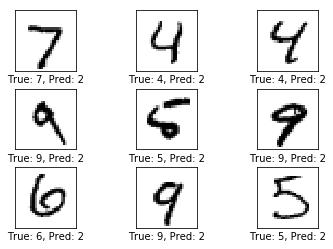

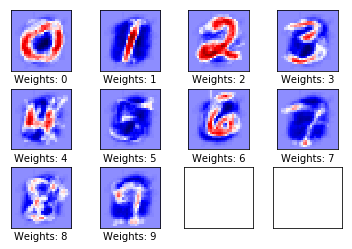

In [53]:
optimize(num_iterations=1)
print_accuracy()
plot_example_errors()
plot_weights()

## Performance after 10 optimization iteration

Accuracy on test-set: 73.4%


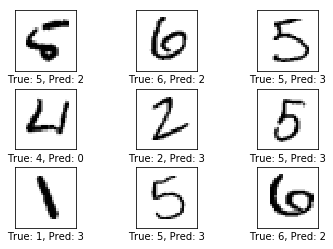

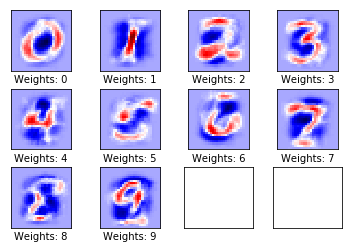

In [54]:
optimize(num_iterations=9)
print_accuracy()
plot_example_errors()
plot_weights()

## Performance after 100 optimization iteration

Accuracy on test-set: 88.6%


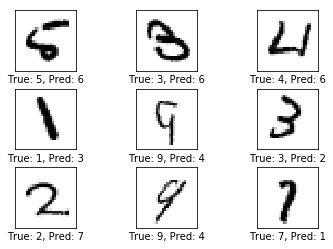

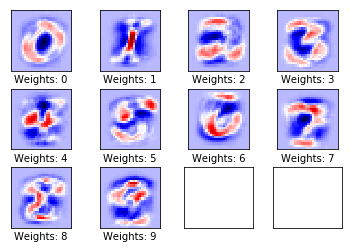

In [55]:
optimize(num_iterations=90)
print_accuracy()
plot_example_errors()
plot_weights()

## Performance after 1000 optimization iteration

Accuracy on test-set: 91.7%


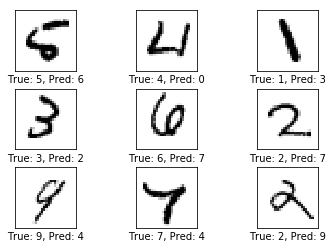

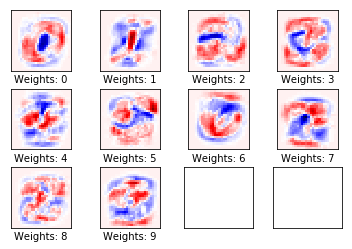

In [57]:
optimize(num_iterations=900)
print_accuracy()
plot_example_errors()
plot_weights()

[[ 968    0    0    1    0    3    6    1    1    0]
 [   0 1102    1    4    1    5    4    2   16    0]
 [  12    8  894   20   17    5   14   16   39    7]
 [   4    0   11  913    1   37    2   12   21    9]
 [   2    2    2    1  921    0    8    2    8   36]
 [  11    3    1   22    9  793   12    7   27    7]
 [  17    3    4    2   24   25  879    2    2    0]
 [   4    6   18    9    7    0    0  951    4   29]
 [   8    5    6   18    9   38    8   14  864    4]
 [  13    5    1   10   49   10    0   28   11  882]]


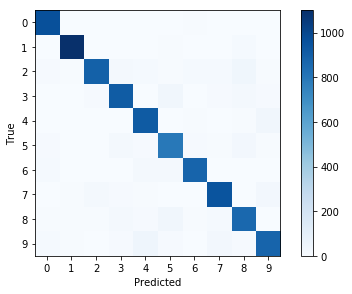

In [59]:
print_confusion_matrix()

# How we can improve results?
## Tuning Hyperparameters

In [17]:
import tensorflow as tf
from util.mnist import MNIST

data = MNIST(data_dir="data/MNIST")

img_size_flat = data.img_size_flat
img_shape = data.img_shape
num_classes = data.num_classes

def SVM(LR, batch_size, niter):
    x = tf.placeholder(tf.float32, [None, img_size_flat])
    y_true = tf.placeholder(tf.float32, [None, num_classes])
    y_true_cls = tf.placeholder(tf.int64, [None])
    
    weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
    biases = tf.Variable(tf.zeros([num_classes]))
    
    logits = tf.matmul(x, weights) + biases
    
    y_pred = tf.nn.softmax(logits)
    y_pred_cls = tf.argmax(y_pred, axis=1)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
    cost = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=LR).minimize(cost)
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as session: 
        session.run(tf.global_variables_initializer())
        feed_dict_test = {x: data.x_test,
                          y_true: data.y_test,
                          y_true_cls: data.y_test_cls}
        
        for i in range(niter):
            x_batch, y_true_batch, _ = data.random_batch(batch_size=batch_size)
            feed_dict_train = {x: x_batch,
                               y_true: y_true_batch}
            session.run(optimizer, feed_dict=feed_dict_train)
        
        acc = session.run(accuracy, feed_dict=feed_dict_test)
        print("Accuracy on test-set: {0:.1%}".format(acc))

In [18]:
%%time
SVM(LR=0.5, batch_size=100, niter=1000)

Accuracy on test-set: 91.6%
CPU times: user 1.42 s, sys: 108 ms, total: 1.53 s
Wall time: 974 ms


In [19]:
%%time
SVM(LR=0.05, batch_size=100, niter=1000)

Accuracy on test-set: 90.1%
CPU times: user 1.46 s, sys: 80 ms, total: 1.54 s
Wall time: 992 ms


In [20]:
%%time
SVM(LR=0.005, batch_size=100, niter=1000)

Accuracy on test-set: 85.2%
CPU times: user 1.44 s, sys: 84 ms, total: 1.53 s
Wall time: 979 ms


In [21]:
%%time
SVM(LR=0.05, batch_size=10, niter=1000)

Accuracy on test-set: 89.5%
CPU times: user 840 ms, sys: 36 ms, total: 876 ms
Wall time: 598 ms


In [22]:
%%time
SVM(LR=0.05, batch_size=1000, niter=1000)

Accuracy on test-set: 90.1%
CPU times: user 7.14 s, sys: 1.28 s, total: 8.42 s
Wall time: 5.57 s


In [23]:
%%time
SVM(LR=0.05, batch_size=100, niter=10000)

Accuracy on test-set: 92.1%
CPU times: user 13 s, sys: 712 ms, total: 13.7 s
Wall time: 8.4 s
